In [ ]:
import pvdeg

## Implemented PVLIB temperature models in PVDEG 

In [ ]:
cell_temp = pvdeg.scenario.Scenario(
    name = 'cell temp',
)

cell_temp.addLocation(
    lat_long=(25.783388, -80.189029), 
    see_added=True,
)

cell_temp.addModule(
    module_name='mod1',
    racking='open_rack_glass_polymer',
    material='EVA',
    temperature_model='sapm'
)

## testing

In [ ]:
import pvlib
parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
print(parameters)

In [1]:
import os
import pandas as pd
import pvdeg
from pvdeg import TEST_DATA_DIR
import json
import pvlib
import matplotlib.pyplot as plt

with open(os.path.join(TEST_DATA_DIR, "meta.json"), "r") as j:
    META = json.load(j)

# Load weather data
WEATHER = pd.read_csv(
    os.path.join(TEST_DATA_DIR, "weather_day_pytest.csv"), index_col=0, parse_dates=True
)

# Load input dataframes
input_data = pd.read_csv(
    os.path.join(TEST_DATA_DIR, r"input_day_pytest.csv"), index_col=0, parse_dates=True
)
poa = [col for col in input_data.columns if "poa" in col]
poa = input_data[poa]

# load expected results
modtemp_expected = input_data["module_temp"]
celltemp_expected = input_data["cell_temp"]

In [40]:
# all tempearature models
result_df = pd.DataFrame()

result_df['sapm_cell'] = pvdeg.temperature.temperature(
    cell_or_mod='cell',
    temp_model='sapm',
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    conf='open_rack_glass_polymer',
    wind_factor=0 
)

result_df['sapm_module'] = pvdeg.temperature.temperature(
    cell_or_mod='mod',
    temp_model='sapm',
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    conf='open_rack_glass_polymer',
    wind_factor=0
)

result_df['pvsyst_cell'] = pvdeg.temperature.temperature(
    cell_or_mod='cell',
    temp_model='pvsyst',
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    conf='freestanding', # different configurations
    wind_factor=0
)

result_df['faiman'] = pvdeg.temperature.temperature(
    temp_model='faiman', 
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    wind_factor=0   
)

result_df['faiman_rad'] = pvdeg.temperature.temperature(
    temp_model='faiman_rad', 
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    wind_factor=0   
)

result_df['fuentes'] = pvdeg.temperature.temperature(
    temp_model='fuentes',
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    wind_factor=0,
    model_kwarg={'noct_installed' : 45} # 45 [c] for freestanding modules
)

noct = pvlib.temperature.sapm_cell(poa_global=800, temp_air=20, wind_speed=1, **pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'])
result_df['ross'] = pvdeg.temperature.temperature(
    temp_model='ross',
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    wind_factor=0,
    model_kwarg={'noct' : noct}
)

result_df['noct_sam'] = pvdeg.temperature.temperature(
    temp_model='noct_sam',
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    wind_factor=0,
    model_kwarg={'noct' : noct, 'module_efficiency' : 0.1875} # 18.75% at 300 [W] / (1000 [W/m^2] * 1.6 [m^2])
)

result_df['generic_linear'] = pvdeg.temperature.temperature(
    temp_model='genaric_linear',
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    wind_factor=0
)

<Axes: >

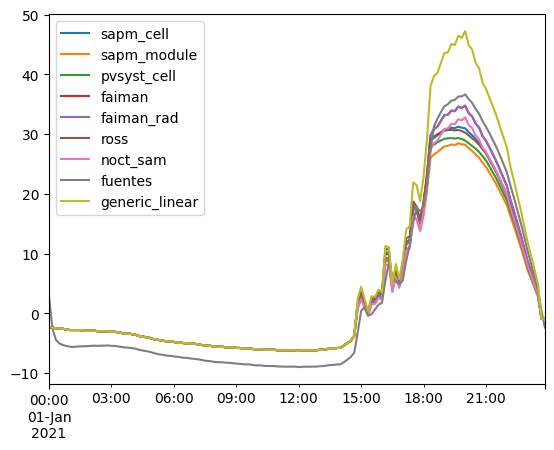

In [71]:
result_df.plot()

In [68]:
glm = pvlib.temperature.GenericLinearModel(
    module_efficiency=0.1875,
    absorptance=0.85
)
glm.use_faiman(16, 8)

result_df['generic_linear'] = pvdeg.temperature.temperature(
    temp_model='generic_linear',
    weather_df=WEATHER,
    meta=META,
    poa=poa,
    wind_factor=0,
    model_kwarg={
        'u_const' : glm.__dict__['u_const'],
        'du_wind' : glm.__dict__['du_wind'],
        'module_efficiency' : 0.1875,
        'absorptance' : 0.85,
    }
)

In [64]:
res = pvlib.temperature.generic_linear(
    poa_global=poa['poa_global'],
    temp_air=WEATHER['temp_air'],
    wind_speed=WEATHER['wind_speed'],
    u_const=glm.__dict__['u_const'],
    du_wind=glm.__dict__['du_wind'],
    module_efficiency=0.1875,
    absorptance=0.85
)

In [81]:
result_df.to_csv(path_or_buf=r"../../tests/data/tempeatures.csv")

In [80]:
display(result_df)

,sapm_cell,sapm_module,pvsyst_cell,faiman,faiman_rad,ross,noct_sam,fuentes,generic_linear
2021-01-01 00:00:00+00:00,-2.300000,-2.300000,-2.300000,-2.300000,-2.300000,-2.300000,-2.300000,2.891669,-2.300000
2021-01-01 00:10:00+00:00,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000,-2.400000,-2.587430,-2.400000
2021-01-01 00:20:00+00:00,-2.500000,-2.500000,-2.500000,-2.500000,-2.500000,-2.500000,-2.500000,-4.442488,-2.500000
2021-01-01 00:30:00+00:00,-2.500000,-2.500000,-2.500000,-2.500000,-2.500000,-2.500000,-2.500000,-5.046393,-2.500000
2021-01-01 00:40:00+00:00,-2.600000,-2.600000,-2.600000,-2.600000,-2.600000,-2.600000,-2.600000,-5.311258,-2.600000
...,...,...,...,...,...,...,...,...,...
2021-01-01 23:10:00+00:00,6.530356,5.771742,6.162960,7.041941,7.041941,6.530356,6.416375,8.280425,9.636308
2021-01-01 23:20:00+00:00,4.868199,4.279286,4.582988,5.265343,5.265343,4.868199,4.779715,6.144205,7.279355
2021-01-01 23:30:00+00:00,3.139963,2.727496,2.940205,3.418117,3.418117,3.139963,3.077990,3.915099,4.828701
2021-01-01 23:40:00+00:00,-0.900000,-0.900000,-0.900000,-0.900000,-0.900000,-0.900000,-0.900000,0.333765,-0.900000
